In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gamma
import mgarch


# Define function to compute Black-Litterman weights based on the model inputs
def compute_black_litterman_weights(cov, pi, P, Q1, tau, omega):
    pi = pi.reshape(-1, 1)  # Ensure pi is a column vector
    # Compute the covariance matrix using Black-Litterman formula
    first_part = np.linalg.inv(np.linalg.inv(tau * cov) + np.dot(P.T, np.linalg.solve(omega, P)))
    # Compute the Black-Litterman expected returns
    second_part = np.dot(np.linalg.inv(tau * cov), pi) + np.dot(P.T, np.linalg.solve(omega, Q1))
    return np.dot(first_part, second_part).flatten()  # Flatten the matrix into a vector


def compute_optimal_weights(cov, expected_returns):
    N = cov.shape[0]  # Get the number of stocks from the covariance matrix
    A = np.ones((1, N))
    c = expected_returns.reshape(N, 1)
    b = np.array([1])
    num = np.dot(np.dot(A, np.linalg.inv(cov)), c) - b
    den = np.dot(A, np.dot(np.linalg.inv(cov), A.T))
    return np.dot(np.linalg.inv(cov), (c - (num / den)))

def compute_mgarch_covariance(returns, ndays=1):
    vol = mgarch.mgarch()
    vol.fit(returns)
    cov_nextday = vol.predict(ndays) 
    cov = cov_nextday['cov']
    return cov

# Load data
stocks_data = pd.read_excel('Stock Prices.xlsx').set_index('Dates')
marketcap_data = pd.read_excel('Market Caps.xlsx').set_index('Dates')


# Initialize parameters and lists for results
capital = 1e10  # Initial capital for trading
days_interval = 64  # Interval for rebalancing the portfolio
returns, dates, dates_traded, weights = [], [], [], []

# Loop through stock data at specified intervals to perform trading simulations
for i in range(2213, len(stocks_data), days_interval):
    stocks_training = stocks_data.iloc[0:i]  # Data used for training model
    stocks_testing = stocks_data.iloc[i:i+1]  # Data used for testing model
    
    rts = stocks_training.pct_change().dropna().values  # Calculate returns for training
    rts_views = stocks_training.iloc[-days_interval:].pct_change().mean().values  # Views based on recent interval
   
    # Calculate the GARCH covariance using mgarch
    cov = compute_mgarch_covariance(rts, ndays=1)
    
    # Black-Litterman model parameters and calculations
    tau = 0.025  # Scaling factor for the uncertainty in the prior
    marketcaps = marketcap_data.iloc[i-1]  # Market capitalization at the current rebalance date
    market_weights = marketcaps / marketcaps.sum()  # Calculate market weights from market caps
    pi = tau * np.dot(cov, market_weights)  # Calculate implied excess returns
    views = np.diff(rts_views)  # Differences in views for constructing P matrix
    P = np.eye(len(views), len(stocks_training.columns))  # link matrix for picking views
    Q1 = (views / days_interval).reshape(-1, 1)  # Adjust views vector to an interval basis
    omega = tau * np.diag(np.var(rts, axis=0)[:len(views)])  # Uncertainty of views
    
    # Compute Black-Litterman expected returns and optimal weights
    bl_expected_returns = compute_black_litterman_weights(cov, pi, P, Q1, tau, omega)
    optimal_weights = compute_optimal_weights(cov, bl_expected_returns)
    
    # Trading simulation for the current period
    last_closing_price = stocks_training.iloc[-1]
    amt_of_shares = np.floor((optimal_weights.flatten() * capital) / last_closing_price.values)  # Number of shares to buy
    abs_returns = (amt_of_shares * stocks_testing.values - amt_of_shares * last_closing_price.values)  # Calculate absolute returns
    percent_returns = abs_returns.sum() / capital  # Calculate percentage returns
    
    # Collect results from the current trading period
    returns.append(percent_returns)
    dates.append(stocks_testing.index[0])
    dates_traded.append(stocks_training.index[-1])
    weights.append(optimal_weights)

# Create DataFrame to display results and print it
results_df = pd.DataFrame({'Returns': returns}, index=dates)
print(results_df)



/Users/jorgehernandez/opt/anaconda3/lib/python3.8/site-packages/mgarch/mgarch.py:65: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(R_t[i])) + \


             Returns
2019-04-24  0.004808
2019-07-25 -0.008727
2019-10-24 -0.004664
2020-01-28  0.005169
2020-04-29  0.070416
2020-07-30 -0.079809
2020-10-29 -0.005613
2021-02-02  0.008456
2021-05-05  0.009538
2021-08-05  0.005427
2021-11-04 -0.019153
2022-02-07 -0.012368
2022-05-10 -0.010908
2022-08-11 -0.001546
2022-11-10  0.079032
2023-02-15 -0.002243


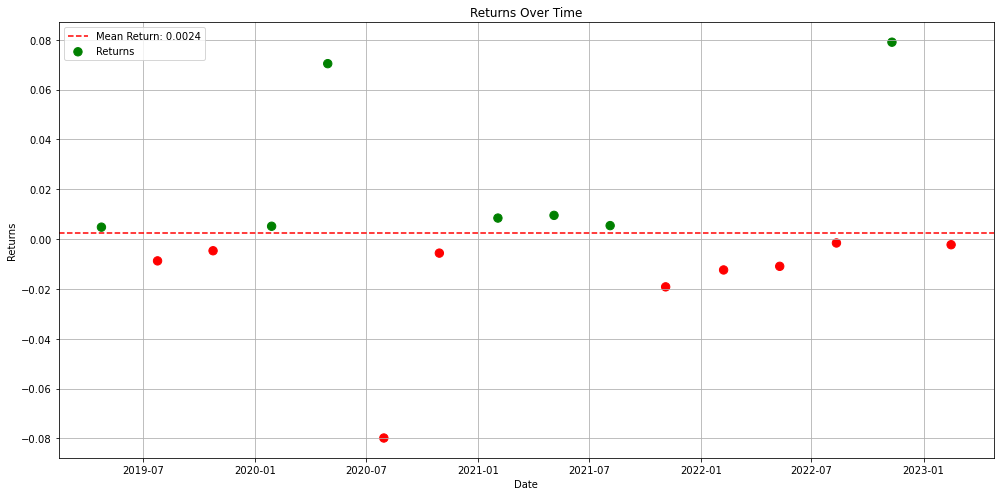

In [14]:
import matplotlib.pyplot as plt

# Calculate the mean return
mean_return = results_df['Returns'].mean()

# Define colors based on return values
colors = ['green' if ret > 0 else 'red' for ret in results_df['Returns']]

# Plotting the returns as scatter plot with color based on return value
plt.figure(figsize=(14, 7))
plt.scatter(results_df.index, results_df['Returns'], label='Returns', color=colors, s=70)  # Adjust size (s) as needed
plt.axhline(y=mean_return, color='red', linestyle='--', label=f"Mean Return: {mean_return:.4f}")
plt.title('Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("Model 1 Returns Over Time.png", dpi=300)  # Adjust dpi for quality

plt.show()


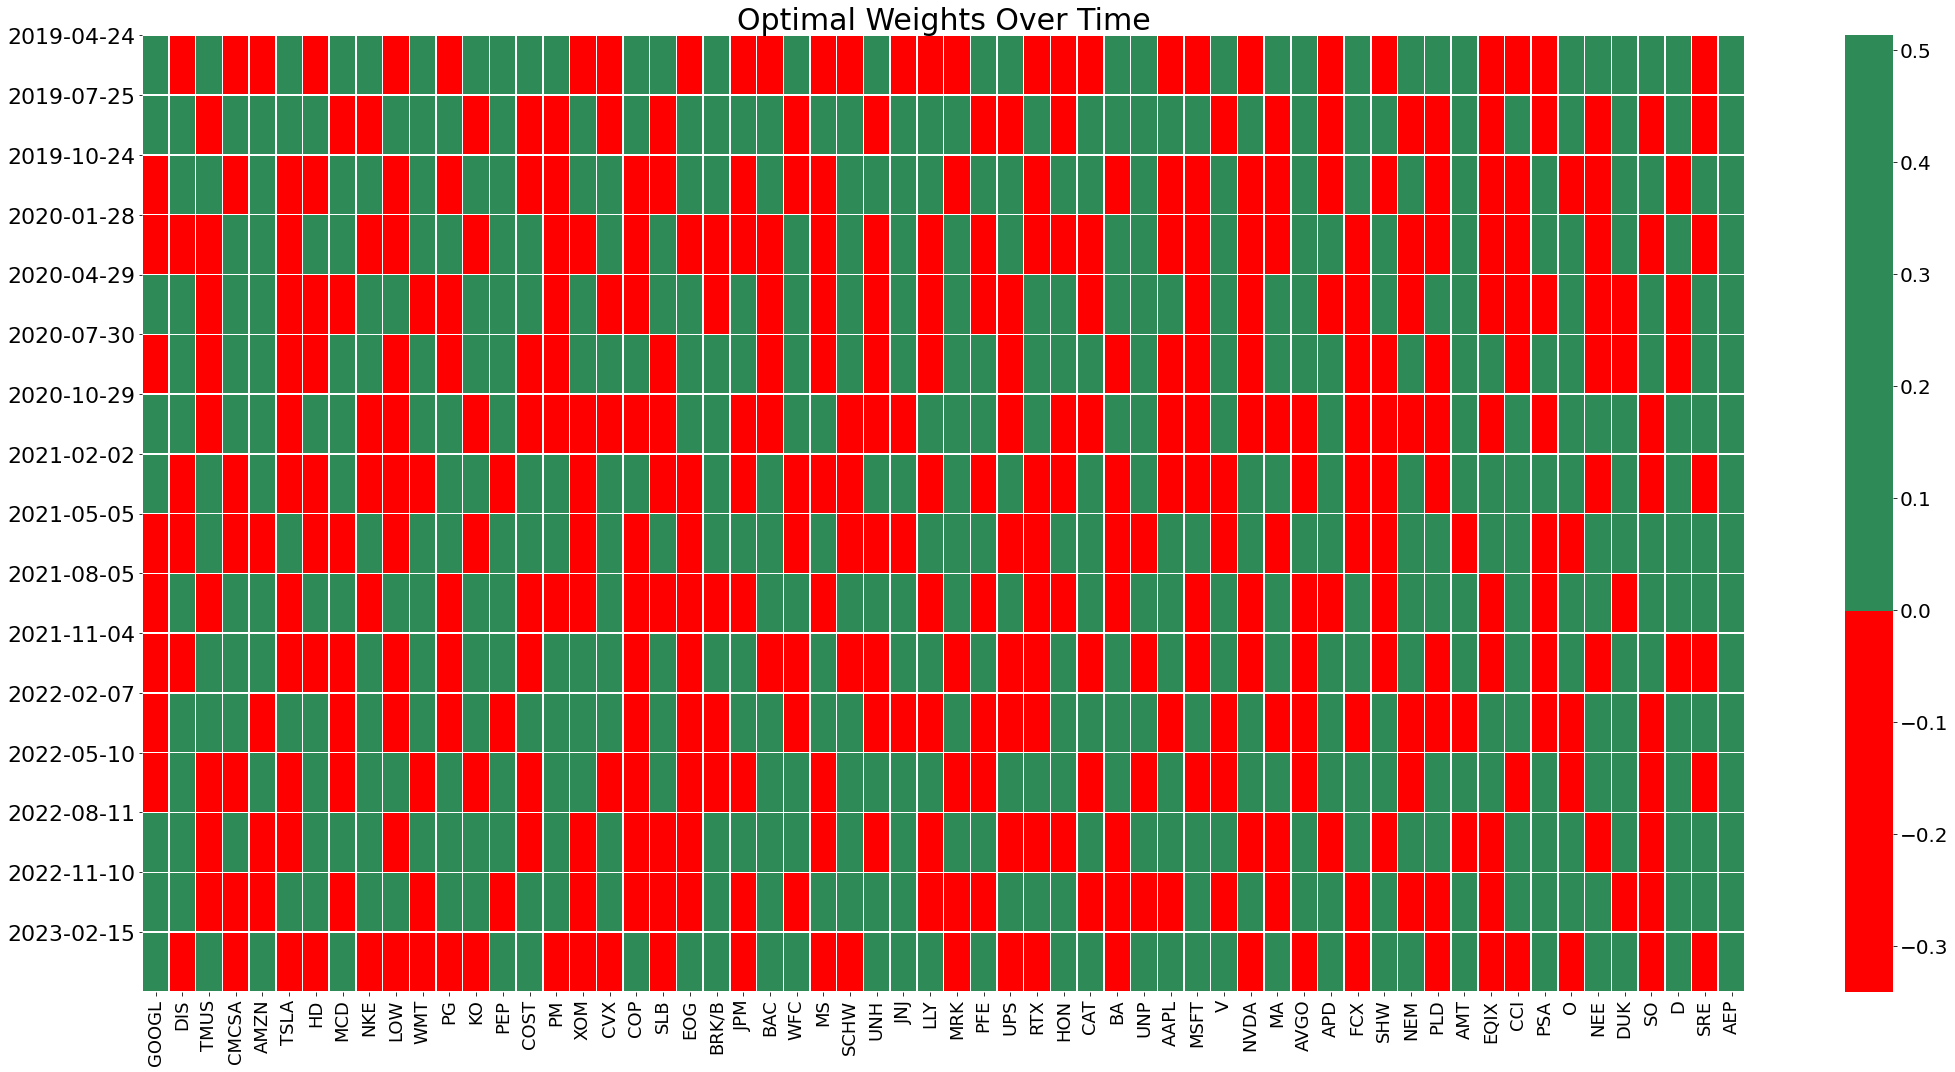

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape weights to 2D
weights_2d = np.array(weights).reshape(len(dates), -1)

# Convert reshaped weights to a DataFrame for easier plotting
weights_df = pd.DataFrame(weights_2d, index=dates, columns=stocks_data.columns)


# Remove "PX_LAST" suffix from stock names in the DataFrame
weights_df.columns = [col.replace('_PX_LAST', '') for col in weights_df.columns]

# Define a custom colormap with red for negative values and green for positive values
colors = ['red', 'seagreen']

cmap = sns.color_palette(colors, as_cmap=True)

# Plotting the heatmap
plt.figure(figsize=(30, 15))
heatmap = sns.heatmap(weights_df, cmap=cmap, cbar=True, linewidths=0.5, center=0)
plt.title('Optimal Weights Over Time', fontsize=30)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(ticks=np.arange(len(weights_df.index)), labels=weights_df.index.strftime('%Y-%m-%d'), fontsize=22)

# Access the color bar object and adjust the font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

plt.savefig("Model 1 Optimal Weights Over Time.png", dpi=300)  # Adjust dpi for quality

plt.show()